In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["zarr"]
_colab_install_missing_deps(deps)

# Reading and writting zarr files with xarray


Created: 2023-03-20

Updated: 2026-02-02



[The zarr format](https://zarr.readthedocs.io/en/stable/) is a file storage based specification for chunked, compressed, N-dimensional arrays. The format is based on an open-source specification and its main goal is to make cloud data read/write a bit easier and more effective.

The main propblems in data storage are:

1. Read/write data that is larger than memory
1. Being able to parallelize computations
1. Reduce the I/O botteneck
1. Compression
1. Speed

One solution is to use a chunked\* parallel computing framework and a chunked parallel storage library. Zarr helps us with the latter.

In this example we will load an ocean model data, stored as netCDF and served via THREDDS, subset it and save as zarr. Let's start by saving a single time step for the surface layer temperature and salinity.


\* Many data formats can take advantage of storing the data in chunks for faster access, the zarr approach is different in that each chunk is a different object in cloud storage, making them better for parallel access. The chunks can be compressed to reduce their size and improve cloud performance even further. Zarr has a nice tutorial on how to balance chunk size for performance. Check it out: https://zarr.readthedocs.io/en/stable/user-guide/performance.html#chunk-optimizations.

In [2]:
import xarray as xr

url = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best_Excluding_Day1"

ds = xr.open_dataset(url)

time_slice = {"time1": "2022-06-06"}
surface = {"s_rho": -1}

ds = ds[["temp", "salt"]].sel(time_slice).isel(surface)

ds

<xarray.Dataset> Size: 821kB
Dimensions:    (time1: 1, eta_rho: 106, xi_rho: 242)
Coordinates:
  * time1      (time1) datetime64[ns] 8B 2022-06-06T12:00:00
    time1_run  (time1) datetime64[ns] 8B ...
    lon_rho    (eta_rho, xi_rho) float64 205kB ...
    lat_rho    (eta_rho, xi_rho) float64 205kB ...
    s_rho      float64 8B -0.0125
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp       (time1, eta_rho, xi_rho) float64 205kB ...
    salt       (time1, eta_rho, xi_rho) float64 205kB ...
Attributes: (12/46)
    file:                            doppio_avg_7309_0001.nc
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS nonlinear model averages file
    title:                           ROMS doppio Real-Time Operational PSAS F...
    var_info:                        ../Data/varinfo1040t_daily.dat
    ...                              ...
    frc_file_07:                     ../Data/Winds_ncepnam_3hourly_MAB_and_Go...
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:doppio_2017_da_avg
    summary:                         doppio
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

In [3]:
import humanize

humanize.naturalsize(ds.nbytes)

'820.9 kB'

It is a small subset but it is enough to ilustrate zarr's compression options.

Now let's choose a compression level and save it as zarr.

In [4]:
from zarr.codecs import BloscCodec

compressor = BloscCodec(clevel=2, shuffle="bitshuffle")


fname = "doppio/doppio_compressed.zarr"

ds.to_zarr(
    fname,
    mode="w",
    safe_chunks=True,
    consolidated=False,
    encoding={var: {"compressors": compressor} for var in ds.variables},
);

In [5]:
!tree doppio/*zarr
!du -h doppio/*zarr

doppio/doppio_compressed.zarr
├── lat_rho
│   ├── c
│   │   └── 0
│   │       └── 0
│   └── zarr.json
├── lon_rho
│   ├── c
│   │   └── 0
│   │       └── 0
│   └── zarr.json
├── salt
│   ├── c
│   │   └── 0
│   │       └── 0
│   │           └── 0
│   └── zarr.json
├── s_rho
│   ├── c
│   └── zarr.json
├── temp
│   ├── c
│   │   └── 0
│   │       └── 0
│   │           └── 0
│   └── zarr.json
├── time1
│   └── zarr.json
├── time1_run
│   └── zarr.json
└── zarr.json

18 directories, 13 files
136K	doppio/doppio_compressed.zarr/salt/c/0/0
140K	doppio/doppio_compressed.zarr/salt/c/0
144K	doppio/doppio_compressed.zarr/salt/c
152K	doppio/doppio_compressed.zarr/salt
8.0K	doppio/doppio_compressed.zarr/time1_run
160K	doppio/doppio_compressed.zarr/lat_rho/c/0
164K	doppio/doppio_compressed.zarr/lat_rho/c
172K	doppio/doppio_compressed.zarr/lat_rho
140K	doppio/doppio_compressed.zarr/temp/c/0/0
144K	doppio/doppio_compressed.zarr/temp/c/0
148K	doppio/doppio_compressed.zarr/temp/c
156K	doppio/doppio_com

The first thing to observe is that the zarr format is a directory based storage. That structure should be familiar for HDF5 users. However, instead of being a filesystem inside a filesystem, zarr is layed out directly on the disk filesystem.

Each variable and coordinate has its own directory and the data chunks are stored in subdirectories. For more information [check this awesome](https://www.youtube.com/watch?v=qyJXBlrdzBs&list=PLKbXDtRY2ZfU6OfZ8JQimBEY-u1WLCpwp) presentation from one of zarr authors.

Note that the stored size is quite smaller too! We went from 820.9 kB to 676 kB. Zarr has many modern compression oprions as plugins, [including some bitinformation based methods](https://xbitinfo.readthedocs.io/en/latest/api/xbitinfo.save_compressed.ToCompressed_Zarr.html).

The data attributes, groups, and metdata are stored in the `.zattrs`, `.zgroup`, and `.zmetadata`. They are plain text JSON files and easy to parse:

In [6]:
import json

with open("doppio/doppio_compressed.zarr/zarr.json") as f:
    zmetadata = json.loads(f.read())


zmetadata

{'attributes': {'file': 'doppio_avg_7309_0001.nc',
  'format': 'netCDF-4/HDF5 file',
  'Conventions': 'CF-1.4, SGRID-0.3',
  'type': 'ROMS/TOMS nonlinear model averages file',
  'title': 'ROMS doppio Real-Time Operational PSAS Forecast System Version 1 FMRC Averages',
  'var_info': '../Data/varinfo1040t_daily.dat',
  'rst_file': 'doppio_rst_7309.nc',
  'his_base': 'doppio_his_7309',
  'avg_base': 'doppio_avg_7309',
  'flt_file': 'doppio_flt_7309.nc',
  'grd_file': '/home/om/roms/doppio/7km/grid_doppio_JJA_v13.nc',
  'ini_file': 'doppio_ini_7309.nc',
  'tide_file': '/home/om/roms/doppio/7km/doppio_tide_7km.nc',
  'frc_file_01': '../PSAS/doppio_flx_7309_outer2.nc',
  'clm_file_01': '../Data/doppio_clm.nc',
  'nud_file': '/home/om/roms/doppio/7km/doppio_nudgcoef_7km_1500-2000_GS.nc',
  'script_file': 'nl_ocean_doppio.in',
  'fpos_file': 'floats.in',
  'NLM_TADV': '\nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:        Akima4       Akima4       \nsalt:        Akima4       Akima4',
  'NLM_

New let's read back the data to check if we can roundtrip it back to the original dataset.

In [7]:
subset = xr.open_zarr(fname, consolidated=False)

subset

<xarray.Dataset> Size: 821kB
Dimensions:    (time1: 1, eta_rho: 106, xi_rho: 242)
Coordinates:
  * time1      (time1) datetime64[ns] 8B 2022-06-06T12:00:00
    time1_run  (time1) datetime64[ns] 8B ...
    lat_rho    (eta_rho, xi_rho) float64 205kB ...
    lon_rho    (eta_rho, xi_rho) float64 205kB ...
    s_rho      float64 8B ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt       (time1, eta_rho, xi_rho) float64 205kB ...
    temp       (time1, eta_rho, xi_rho) float64 205kB ...
Attributes: (12/46)
    file:                            doppio_avg_7309_0001.nc
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS nonlinear model averages file
    title:                           ROMS doppio Real-Time Operational PSAS F...
    var_info:                        ../Data/varinfo1040t_daily.dat
    ...                              ...
    frc_file_07:                     ../Data/Winds_ncepnam_3hourly_MAB_and_Go...
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:doppio_2017_da_avg
    summary:                         doppio
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

And a quick plot to check the data.

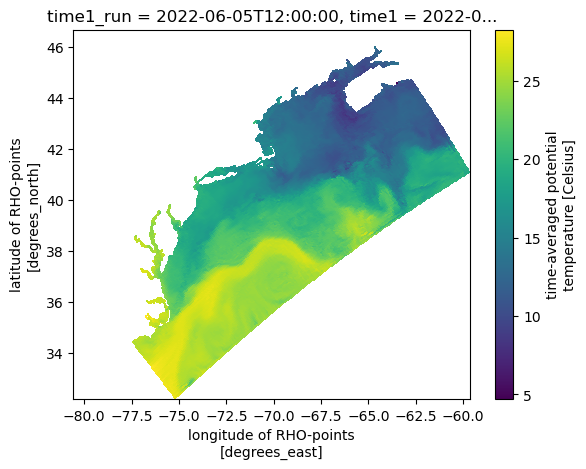

In [8]:
subset["temp"].compute().squeeze().plot(x="lon_rho", y="lat_rho");

What is the current workflow and what are the altearnatives? Most ocean data are stored as modern netCDF files that are, under the hood HDF5 files with more strict metadata stuture. HDF5 has some limitations like,

- no thread-based parallelism
- cannot do parallel writes with compression
- no support for could object stores

However, for most workflows what really matters is the chunking, not the data format. Leaving the parallelism, compression, and cloud support to be built on top of it with `dask`, `numcodecs`, and `fsspec`, respectively. That raises the question: Should one convert all the existing data to `zarr`? Luckily no! We can adopt a more inexpensive workflow and kerchunk to create virtual cloud-optimized CF-compliant datasets that access files in any format using the Zarr library.

We can write the data in whatever format we need (maybe you are NASA and require HDF5, maybe you have R users who like netcdf, or want to use a visualization tool that only reads geotiff), then rechunk the data to best support the expected use cases.